# import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from numpy import pi
import numpy as np
from gemseo import to_pickle


configure_logger()

<RootLogger root (INFO)>

# instanciate discipline 

In [2]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# create uncertain space

In [4]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)


# create sample dataset


In [5]:
dataset = sample_disciplines(disciplines, uncertain_space, ["mtom"], algo_name="OT_MONTE_CARLO", n_samples=1000)

    INFO - 14:49:30: *** Start Sampling execution ***
    INFO - 14:49:30: Sampling
    INFO - 14:49:30:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:49:30:    MDO formulation: MDF
    INFO - 14:49:30: Running the algorithm OT_MONTE_CARLO:
    INFO - 14:49:32:    100%|██████████| 1000/1000 [00:02<00:00, 392.01 it/sec]
    INFO - 14:49:32: *** End Sampling execution (time: 0:00:02.566574) ***


# check stat

In [ ]:
statistics = EmpiricalStatistics(dataset)
mean = statistics.compute_mean()
print(mean)

std = statistics.compute_standard_deviation()
print(std)

# propagate uncertainties

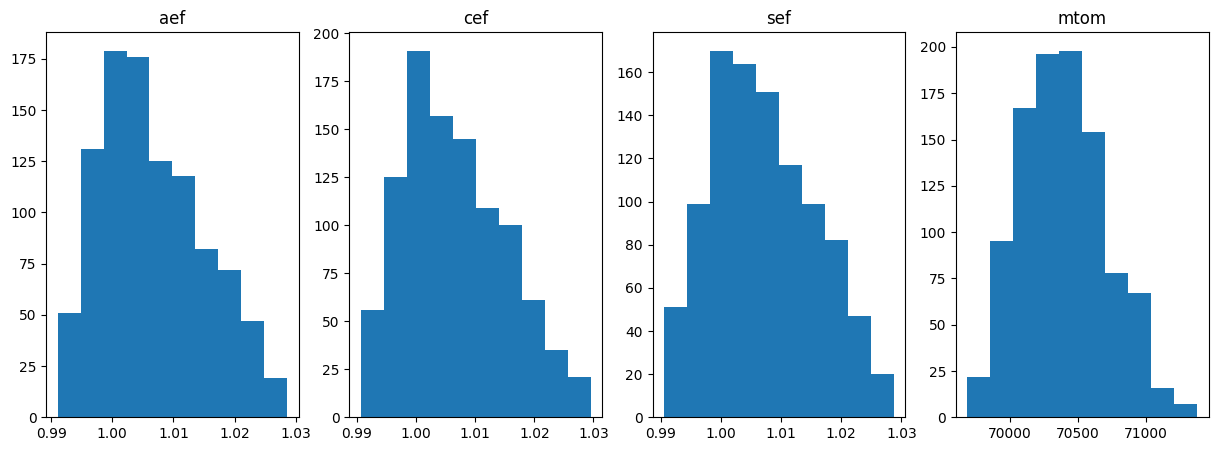

In [9]:
fig, axes = plt.subplots(1, 4, figsize = (15,5))
for ax, name in zip(axes, ["aef", "cef", "sef", "mtom"]):
    ax.hist(dataset.get_view(variable_names=name))
    ax.set_title(name)

# sobol analysis

In [10]:
sobol = SobolAnalysis()
samples = sobol.compute_samples(disciplines, uncertain_space, 10000)
# to_pickle(samples, "samples.pkl")
sobol = SobolAnalysis(samples)
sobol.compute_indices(output_names=["mtom"])

    INFO - 14:58:00: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 14:58:00: SobolAnalysisSamplingPhase
    INFO - 14:58:00:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:58:00:    MDO formulation: MDF
    INFO - 14:58:00: Running the algorithm OT_SOBOL_INDICES:
    INFO - 14:59:01:    100%|██████████| 10000/10000 [01:01<00:00, 163.56 it/sec]
    INFO - 14:59:01: *** End SobolAnalysisSamplingPhase execution (time: 0:01:01.259849) ***


SobolAnalysis.SensitivityIndices(first={'mtom': [{'aef': array([0.06251963]), 'cef': array([0.17536688]), 'sef': array([0.78596208])}]}, second={'mtom': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07151055]]), 'sef': array([[-0.06268684]])}, 'cef': {'aef': array([[-0.07151055]]), 'cef': array([[0.]]), 'sef': array([[-0.10841248]])}, 'sef': {'aef': array([[-0.06268684]]), 'cef': array([[-0.10841248]]), 'sef': array([[0.]])}}]}, total={'mtom': [{'aef': array([0.02694178]), 'cef': array([0.12916223]), 'sef': array([0.80639304])}]})

In [11]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'mtom': [{'aef': array([0.06251963]),
           'cef': array([0.17536688]),
           'sef': array([0.78596208])}]}
{'mtom': [{'aef': array([0.02694178]),
           'cef': array([0.12916223]),
           'sef': array([0.80639304])}]}


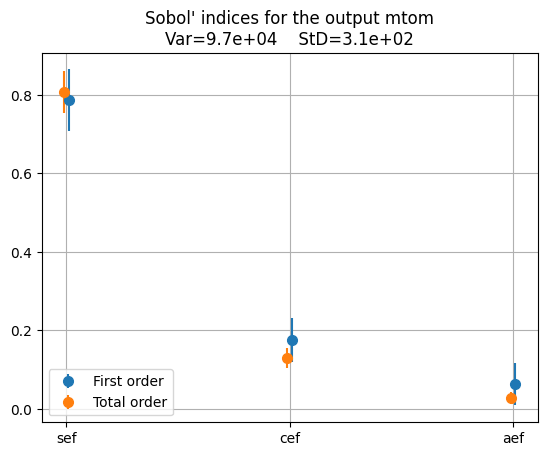

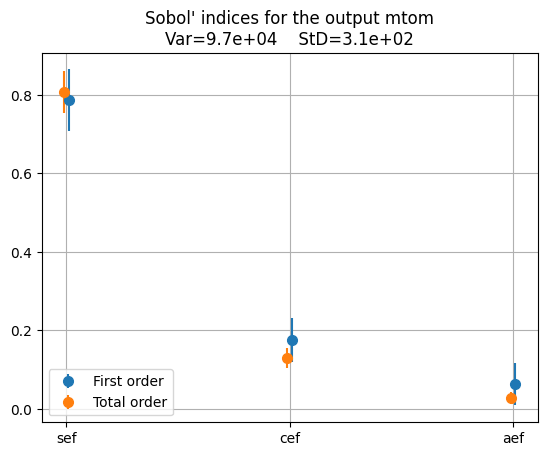

In [12]:
sobol.plot("mtom", save=False, show=False)